# EDA, PCA & Clustering (TRAIN ONLY)

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

np.random.seed(42)


## Load cleaned training data

In [2]:
train_clean_path = "data/claims_train_clean.csv"
df = pd.read_csv(train_clean_path)

print("Shape:", df.shape)
df.head()


Shape: (542410, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
1,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
2,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
3,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
4,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


## Create claims risk variable

In [3]:
df["risk"] = df["ClaimNb"] / df["Exposure"]

df["risk"].describe()


count    542410.000000
mean          0.261201
std           4.428121
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
Name: risk, dtype: float64

## Basic EDA: target distribution

Risk distribution


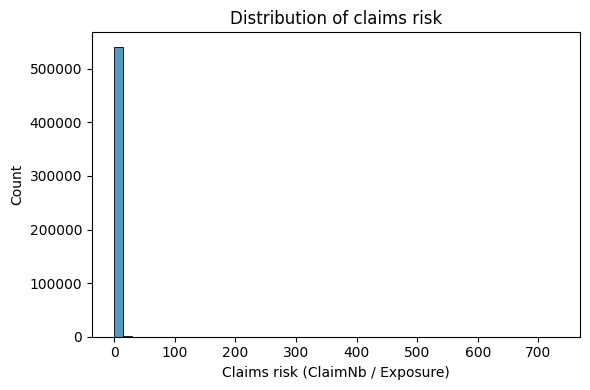

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(df["risk"], bins=50, kde=False)
plt.xlabel("Claims risk (ClaimNb / Exposure)")
plt.ylabel("Count")
plt.title("Distribution of claims risk")
plt.tight_layout()
plt.show()


**Summary:** The distribution of claims risk is highly skewed, with the majority of policies exhibiting zero claims during the observation period. A small number of policies display very high risk values, typically corresponding to multiple claims within short exposure periods.

## Risk vs key numerical features

These plots help justify feature relevance.

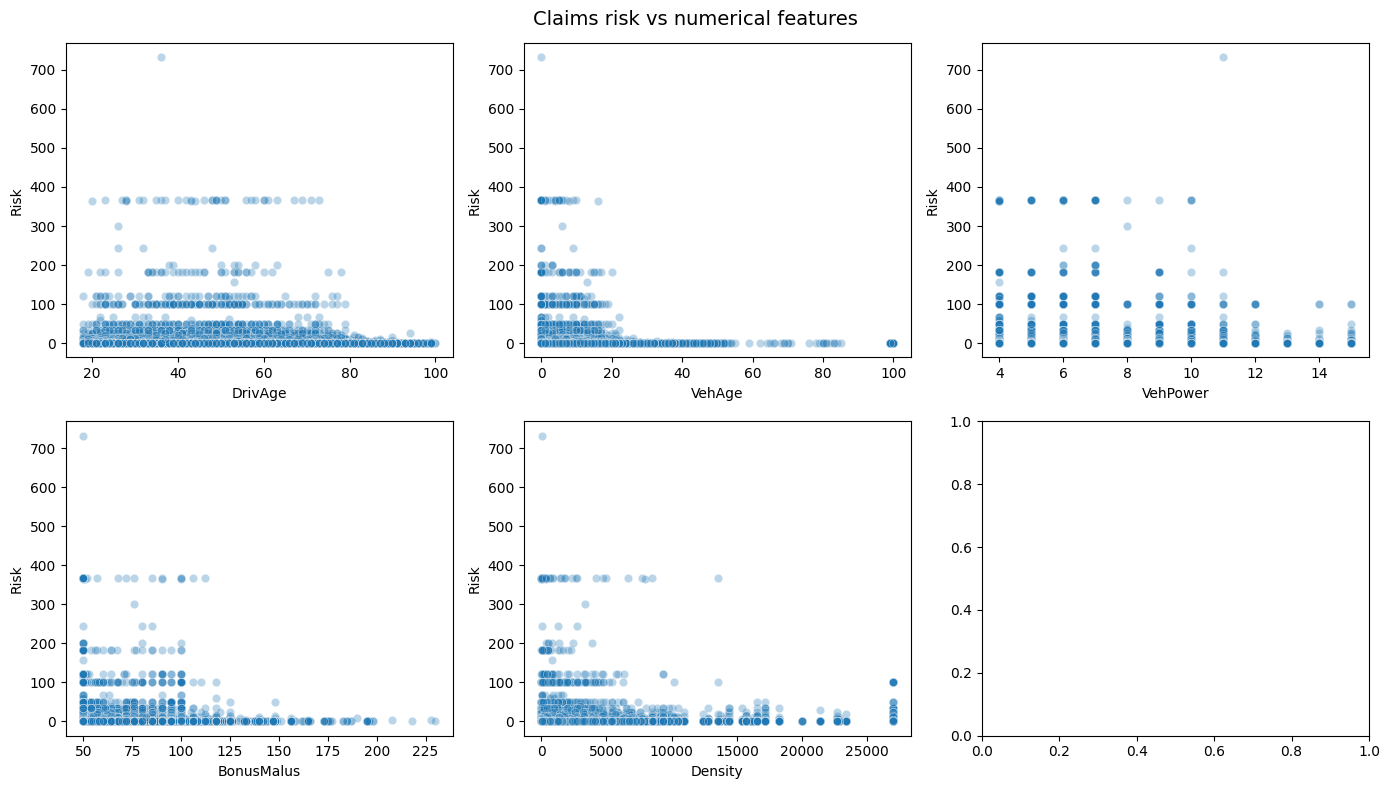

In [6]:
num_features = ["DrivAge", "VehAge", "VehPower", "BonusMalus", "Density"]

fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.flatten()

for ax, col in zip(axes, num_features):
    sns.scatterplot(
        x=df[col],
        y=df["risk"],
        alpha=0.3,
        ax=ax
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Risk")

fig.suptitle("Claims risk vs numerical features", fontsize=14)
plt.tight_layout()
plt.show()


**Summary:** Claims risk exhibits a highly skewed distribution with most observations concentrated near zero, while extreme values occur primarily for younger drivers, newer vehicles, lower bonus–malus scores, and lower population densities.

## Prepare data for PCA & clustering

We use numerical features only, and then we scale them.

In [14]:
pca_features = [
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "Density"
]

X = df[pca_features].values


## Feature scaling

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.mean(axis=0), X_scaled.std(axis=0)


(array([ 1.36446842e-16, -2.47323000e-17, -1.92670905e-16,  4.65302594e-17,
        -2.55706831e-17]),
 array([1., 1., 1., 1., 1.]))

Prior to applying PCA and k-means clustering, all numerical features were standardized to zero mean and unit variance to ensure equal contribution to distance- and variance-based methods.

## PCA

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.30244572 0.21981137]
Total explained variance: 0.5222570878689554


**Summary:**

- PC1 explains ~30%

- PC2 explains ~22%

Together ≈ 52% of total variance

The first two principal components explain approximately 52% of the total variance, indicating that while some structure is captured in two dimensions, a substantial amount of information remains in higher dimensions.

## PCA visualization

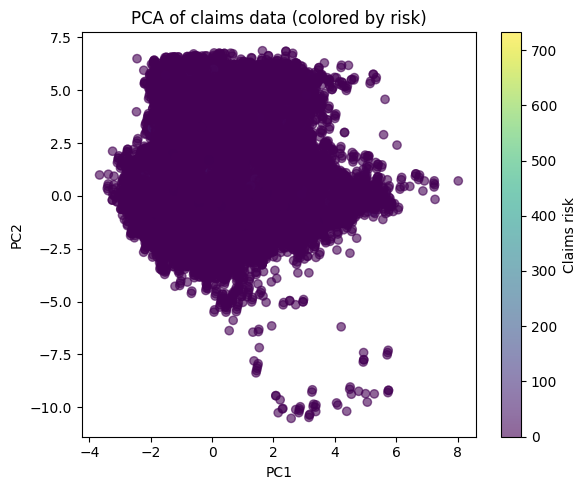

In [18]:
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df["risk"],
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of claims data (colored by risk)")
plt.colorbar(scatter, label="Claims risk")
plt.tight_layout()
plt.show()


**Summary:**
Although the first two principal components explain approximately 52% of the variance, policies with high claims risk are not clearly separated in the reduced space, indicating that risk depends on complex, non-linear combinations of features.

## Log-color scale

Because risk is extremely skewed, we add a log-color scale

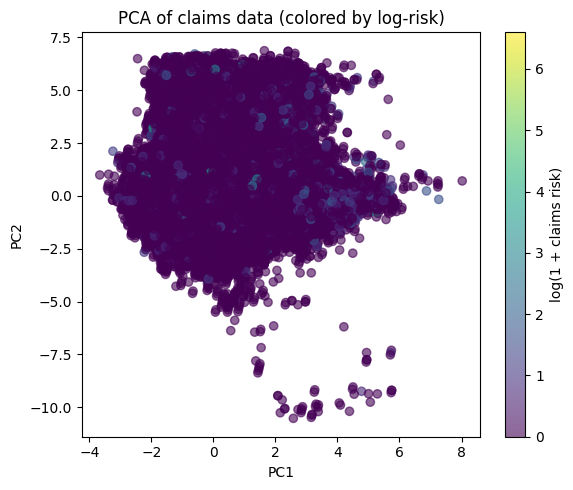

In [23]:
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=np.log1p(df["risk"]),
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of claims data (colored by log-risk)")
plt.colorbar(scatter, label="log(1 + claims risk)")
plt.tight_layout()
plt.show()


## K-means clustering

In [19]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters
df["cluster"].value_counts()


cluster
1    255994
2    164837
0    121579
Name: count, dtype: int64

The k-means algorithm produced three clusters of unequal but substantial size, indicating heterogeneity in policy characteristics rather than the presence of small outlier clusters.

## Clusters in PCA space

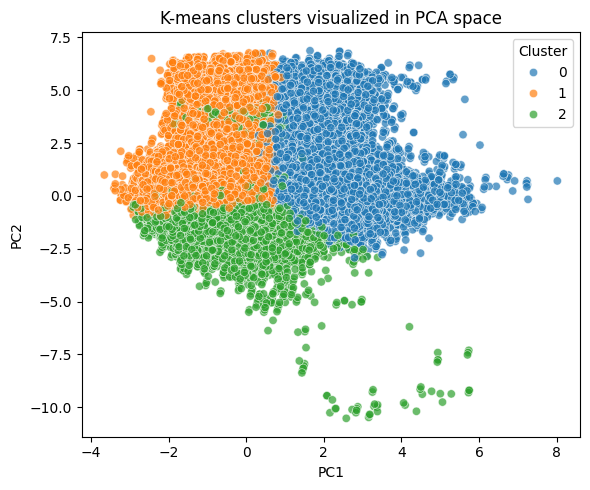

In [20]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df["cluster"],
    palette="tab10",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means clusters visualized in PCA space")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


**Summary:**

When visualized in PCA space, the clusters show partial separation, indicating that the numerical characteristics reflect a meaningful structure, although significant overlap remains.

## Interpret clusters

In [22]:
cluster_summary = (
    df.groupby("cluster")[pca_features + ["risk"]]
      .mean()
      .round(2)
)

cluster_summary


,VehPower,VehAge,DrivAge,BonusMalus,Density,risk
cluster,,,,,,
0,6.06,7.34,31.50,84.41,2433.61,0.34
1,6.66,3.09,50.85,52.27,1964.82,0.31
2,6.41,12.97,47.53,53.22,1064.12,0.13


**Interpretation:**

Cluster 0 corresponds to relatively young drivers operating in denser areas and exhibits the highest average claims risk.

Cluster 1 represents older drivers with newer vehicles and exhibits intermediate risk levels.

Cluster 2 contains policies associated with older vehicles and lower population densities and shows the lowest average claims risk.

### Conclusion


The exploratory analysis shows that claims risk is highly skewed, with most policies having zero claims and a small number exhibiting very high risk. PCA and clustering reveal some structure in the data, but high-risk policies are not clearly separable, indicating that risk depends on complex, non-linear feature interactions. These observations motivate the use of flexible machine learning models in subsequent analysis.